In [1]:
# Uncomment this to install dependencies for this notebook
# !pip install gym
# !pip install tqdm
# !pip install tensorboard
# !pip install ipympl

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import tqdm
import torch.optim as optim


In [3]:
from hypernn.torch.hypernet import TorchHyperNetwork
from hypernn.torch.weight_generator import TorchWeightGenerator
from hypernn.torch.embedding_module import TorchEmbeddingModule

## Basic Hypernetwork

### 3 Components:
- EmbeddingModule: Layer / general parameter embeddings to be passed into the weight generator
- WeightGenerator: Shared network used to generate parameters from each embedding in the EmbeddingModule
- Hypernetwork: Combines EmbeddingModule & WeightGenerator for end to end parameter generator

### EmbeddingModule

In [4]:
from typing import Optional, Any

class DefaultTorchEmbeddingModule(TorchEmbeddingModule):
    def __init__(self, embedding_dim: int, num_embeddings: int):
        super().__init__(embedding_dim, num_embeddings)
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, inp: Optional[Any] = None, *args, **kwargs):
        indices = torch.arange(self.num_embeddings).to(self.device)
        return self.embedding(indices)


### Weight Generator

In [5]:
class StaticTorchWeightGenerator(TorchWeightGenerator):
    def __init__(self, embedding_dim: int, hidden_dim: int):
        super().__init__(embedding_dim, hidden_dim)
        self.linear1 = nn.Linear(embedding_dim, 32)
        self.linear2 = nn.Linear(32, hidden_dim)

    def forward(
        self, embedding: torch.Tensor, inp: Optional[Any] = None
    ) -> torch.Tensor:
        x = self.linear1(embedding)
        x = F.relu(x)
        return self.linear2(x).view(-1)



### Making a LunarLander HyperNetwork

#### Big Target Network

In [6]:
target_network = nn.Sequential(
    nn.Linear(8, 256),
    nn.Tanh(),
    nn.Linear(256,256),
    nn.Tanh(),
    nn.Linear(256, 4, bias=False)
)
pytorch_total_params = sum(p.numel() for p in target_network.parameters() if p.requires_grad)
pytorch_total_params

69120

#### Much smaller Hypernetwork, with lots of parameter sharing

In [7]:
hypernetwork = TorchHyperNetwork(
                            target_network,
                            embedding_module_constructor=DefaultTorchEmbeddingModule,
                            weight_generator_constructor=StaticTorchWeightGenerator,
                            embedding_dim = 32,
                            num_embeddings = 512
                        )
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

21895

In [8]:
def rollout(env, hypernetwork, render=False) -> float:
    with torch.no_grad():
        params = hypernetwork.generate_params()
        obs = env.reset()
        done = False
        observations, actions, rewards, rendereds = [], [], [], []
        while not done:
            rendered = None
            if render:
                rendered = env.render(mode="rgb_array")
                rendereds.append(rendered)

            action_logits, _ = hypernetwork(torch.from_numpy(obs).unsqueeze(0), params=params)
            dist = Categorical(logits=action_logits)
            action = dist.sample().item()
            next_obs, r, done, _ = env.step(action)

            observations.append(obs)
            actions.append(action)
            rewards.append(r)

            obs = next_obs

    env.close()
    return observations, actions, rewards, rendereds

#### Tensorboard logging

In [9]:
import os
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def get_tensorboard_logger(
    experiment_name: str, base_log_path: str = "tensorboard_logs"
):
    log_path = "{}/{}_{}".format(base_log_path, experiment_name, datetime.now())
    train_writer = SummaryWriter(log_path, flush_secs=10)
    full_log_path = os.path.join(os.getcwd(), log_path)
    print(
        "Follow tensorboard logs with: python -m tensorboard.main --logdir '{}'".format(full_log_path)
    )
    return train_writer


In [10]:
def discount_reward(rews, gamma: float = 0.99):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + gamma*(rtgs[i + 1] if i + 1 < n else 0)
    return rtgs

def reinforce(
        num_epochs,
        env,
        hypernetwork,
        lr: float = 0.0001,
        gamma: float = 0.99,
    ):

    writer = get_tensorboard_logger("HypernetworkTorchRL")
    optimizer = optim.Adam(hypernetwork.parameters(), lr=lr)

    bar = tqdm.tqdm(np.arange(num_epochs))
    for i in bar:
        observations, actions, rewards, _ = rollout(env, hypernetwork)

        discounted_rewards = discount_reward(np.array(rewards), gamma)
        discounted_rewards = discounted_rewards - np.mean(discounted_rewards)
        discounted_rewards = discounted_rewards / (
            np.std(discounted_rewards) + 1e-10
        )

        observations = torch.from_numpy(np.array(observations)).float().to(hypernetwork.device)
        actions = torch.from_numpy(np.array(actions)).float().to(hypernetwork.device)
        discounted_rewards = torch.from_numpy(discounted_rewards).float().to(hypernetwork.device)

        logits, _ = hypernetwork(observations)
        dist = Categorical(logits=logits)
        log_probs = dist.log_prob(actions)

        optimizer.zero_grad()
        loss = -1 * torch.sum(discounted_rewards * log_probs)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(hypernetwork.parameters(), 10.0)
        optimizer.step()

        grad_dict = {}
        for n, W in hypernetwork.named_parameters():
            if W.grad is not None:
                grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

        metrics = {"loss":loss.item(), "rewards":np.sum(rewards), **grad_dict}

        for key in metrics:
            writer.add_scalar(key, metrics[key], i)

        bar.set_description('Loss: {}, Sum Reward: {}'.format(loss.item(), np.sum(rewards)))


In [11]:
env = gym.make("LunarLander-v2")

In [12]:
reinforce(100000, env, hypernetwork)

Follow tensorboard logs with: python -m tensorboard.main --logdir '/home/shyam/Code/hyper-nn/notebooks/tensorboard_logs/HypernetworkTorchRL_2022-03-14 22:09:54.435272'


Loss: 3.263174295425415, Sum Reward: 24.157279283736216:   4%|▍         | 3822/100000 [12:25<5:12:28,  5.13it/s]     


KeyboardInterrupt: 

In [13]:
env = gym.make("LunarLander-v2")
observations, actions, rewards, rendereds = rollout(env, hypernetwork, render=True)

In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib ipympl

plt.style.use('ggplot')
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from celluloid import Camera
from IPython.display import HTML


def render_rollout(model):
    fig = plt.figure("Animation",figsize=(7,5))
    camera = Camera(fig)
    ax = fig.add_subplot(111)
    observations, actions, rewards, rendereds = rollout(gym.make("LunarLander-v2"), model, render=True)
    frames = []
    for r in rendereds:
        frame = ax.imshow(r)
        ax.axis('off')
        camera.snap()
        frames.append([frame])
    animation = camera.animate(blit=False, interval=50)
    # display(animations.to_html5_video())
    animation.save('animation.mp4')
    return animation


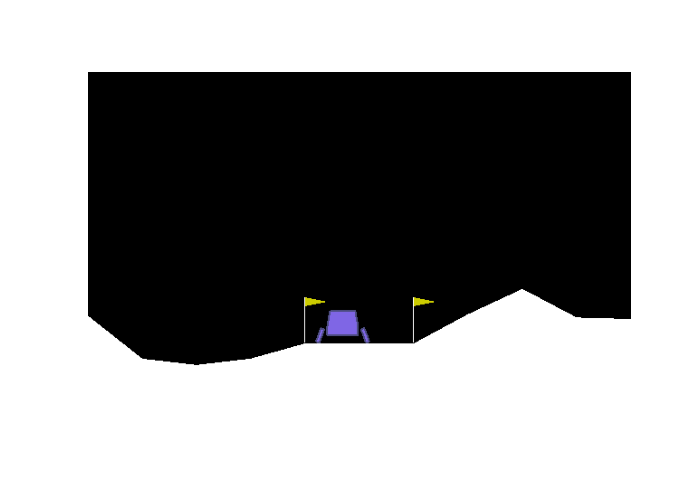

In [20]:
vid = render_rollout(hypernetwork)

In [21]:
from IPython.display import Video

Video("animation.mp4")